# Graph Neural Networks: Application

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Simulate Complex Flows with Graph Networks

In this week, we will explore an application of GNN on free surface flows.  

We will go over the implementation of a recent work we had previously discussed in the lecture "[Learning to Simulate Complex Physics with Graph Networks](https://arxiv.org/abs/2002.09405)". 

In the original study comes from DeepMind and utilizes the Graph Net library we discussed in our last exercise. We will go over its implementation in pytorch geometric and how it can be used to solve a complex fluid flow problem.

You may access the code from [here](https://github.com/deepmind/deepmind-research). 






## Required libraries


In [ ]:
# Basic libraries:
import os
import json
import math
import numpy as np 
import time

# Plotters:
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') 
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

# Helpers
from tqdm.notebook import tqdm

# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=12, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

# ML libraries
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


In [ ]:
# Setting the seed
pl.seed_everything(2022)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
# GPU Check:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# NOTE:
# This week datasets and models are quite simple so the notebook is saved on cpu mode. If you wish,
# you can change the runtime type. 

Global seed set to 2022


cuda:0


In [ ]:
# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # To istalling torch geometric packages, we need to specify CUDA+PyTorch version; 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for more.  
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [ ]:
# Importing libraries:
import torch_geometric
from torch_geometric.utils import to_networkx
# importing package to design NNs and data management: 
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

In [ ]:
!pip3 install tfrecord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.9 MB/s 
  Created wheel for tfrecord: filename=tfrecord-1.14.1-py3-none-any.whl size=15652 sha256=5bf5562ca6ecd1f26c96f2958ec969447ace382ee0ef157d2f37d30f844d7c8c
  Stored in directory: /root/.cache/pip/wheels/07/63/59/2a382bd2e3051f622bf8742e79f2641d78b29523680f57bf74
Successfully built tfrecord


In [ ]:
# Libraries
import os
import json
import pickle
import numpy as np


In [ ]:
import torch_geometric as pyg
from torch_geometric.nn import radius_graph

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.makedirs('train_log', exist_ok=True)
os.makedirs('rollouts', exist_ok=True)

# Loading data from cloud

The dataset we will be using is coming from the same study. Since it is prepared for the proposed workframe, we need to manage the data conversion process. 

The training data from DeepMind was given in the form of tfrecords. So, we need to convert them in a way that it can be processed in PyG. It is not of particular importance for this exercise, yet we need to integrate it to our workflow. 

The data is available at Google Drive and we will link it at the cloud machine.

In [ ]:
#Mounting the folder 
# In my case, I created a folder under my drive: My Drive >DDE_2 > GNN
#This is why I will pass this folder structure with a symbolic link
#https://www.freecodecamp.org/news/symlink-tutorial-in-linux-how-to-create-and-remove-a-symbolic-link/
#
#Lets first mount the drive as gdrive:
from google.colab import drive
drive.mount('/content/gdrive')
%ls

Mounted at /content/gdrive
'=1.4'   gdrive/   rollouts/   sample_data/   train_log/


In [ ]:
#Now creating the symbolic link:
!ln -s /content/gdrive/My\ Drive/DDE_2/GNN/ /mydrive
!ls /mydrive/WaterDrop/

metadata.json  test.tfrecord  trained_model  train_log	valid.tfrecord


The dataset we are using is the WaterDrop set. Here the fluid phase is represented by around 2000 discrete elements. Reference solutions come from material point method (MPM) simulations. 

You can have a look for more:

https://sites.google.com/view/learning-to-simulate#h.p_AMiqgaqebAtR


As you can see above, we have two type of data: tfrecord files and a metadata file in json format. 

The metadata file includes: 
* The sequence length of each case,
* The dimensionality of the problem (in this case 2D),
* The box bounds (borders of the solution domain),
* The default connectivity radius (range of each particle's neighborhood)
* The statistics for normalization (mean and standard deviation of the velocity and acceleration of particles).

In the dataset, each point includes:
1. The type of the particles (water, sand etc)
2. The particle positions at each frame.

# How to Design a Graph from the Feature Data

Our goal is to create a Simulator: given the initial state of the fluids, we should be able to unroll in time and make predicitons. We will approach it as a **node level regression task**. Our labels will be the **particle accelerations**.

The base input of the model will be previous positions of the fluid elements (as a hyperparameter). Model will observe the motion of the fluid elements, and will predict the accelation of each fluid element, which can be then used to estimate the velocity and the position (basic integration). 

In the dataset, we only know:

* position of the fluid elements, organized as a sequence,
* length of each simulation,
* size of the domain,
* radius of neighbourhood,
* expected statistics for data normalization.


In order to create a graph, we need to identify:

* node features 
* edges (sender and receiver nodes)
* edge features
* global features if applicable. 


So, we need to do the following:

1. Extract node-level features. Ideas to try: particle positions, velocities and their distance to the boundary 

2. Construct node connectivity: here we will use distance between particles (i.e., radius of neighbourhood)

3. Extract edge-level features. Ideas to try: displacement and distance between particles.


To augment the training and have a better generalizability, we will also apply some noise to the splash simulations so that they will be slightly different for each training cycle. To do so, we will create some noise generators.  

### Hyperparameters

In [ ]:
# How many past position vectors will be used?
INPUT_SEQUENCE_LENGTH = 6
# Training parameters:
batch_size = 2
training_steps = int(2e7)
# Keeping log and saving intermediate models:
log_steps = 5
eval_steps = 20
save_steps = 100
model_path = "/mydrive/WaterDrop/trained_model" 
#Device:
device = 'cuda'
# Data augmentation:
noise_std = 6.7e-4

In [ ]:
# For data normalization, we will need the statistics: 
#--------------------------------------------------------
with open('/mydrive/WaterDrop/metadata.json', 'rt') as f:
    metadata = json.loads(f.read())
# Reading total sequence length:
num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH
# Data normalization dict:
normalization_stats = {
    'acceleration': {
        'mean':torch.FloatTensor(metadata['acc_mean']).to(device), 
        'std':torch.sqrt(torch.FloatTensor(metadata['acc_std'])**2 + noise_std**2).to(device),
    }, 
    'velocity': {
        'mean':torch.FloatTensor(metadata['vel_mean']).to(device), 
        'std':torch.sqrt(torch.FloatTensor(metadata['vel_std'])**2 + noise_std**2).to(device),
    }, 
}

In [ ]:
# Lets see the data:
normalization_stats

{'acceleration': {'mean': tensor([-1.1071e-08,  8.7494e-08], device='cuda:0'),
  'std': tensor([0.0007, 0.0007], device='cuda:0')},
 'velocity': {'mean': tensor([ 1.1928e-05, -2.5633e-04], device='cuda:0'),
  'std': tensor([0.0015, 0.0015], device='cuda:0')}}

In [ ]:
# Helper function:
def _read_metadata(data_path):
    with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
        return json.loads(fp.read())

## Data preparation

The job of this function is to get the data from tfrecord files.

In [ ]:
def prepare_data_from_tfds(data_path='/mydrive/WaterDrop/valid.tfrecord', is_rollout=False, batch_size=2):
    import functools
    import tensorflow.compat.v1 as tf
    import tensorflow_datasets as tfds
    import reading_utils
    import tree
    from tfrecord.torch.dataset import TFRecordDataset
    def prepare_inputs(tensor_dict):
        pos = tensor_dict['position']
        pos = tf.transpose(pos, perm=[1, 0, 2])
        target_position = pos[:, -1]
        tensor_dict['position'] = pos[:, :-1]
        num_particles = tf.shape(pos)[0]
        tensor_dict['n_particles_per_example'] = num_particles[tf.newaxis]
        if 'step_context' in tensor_dict:
            tensor_dict['step_context'] = tensor_dict['step_context'][-2]
            tensor_dict['step_context'] = tensor_dict['step_context'][tf.newaxis]
        return tensor_dict, target_position
    def batch_concat(dataset, batch_size):
        windowed_ds = dataset.window(batch_size)
        initial_state = tree.map_structure(lambda spec: tf.zeros(shape=[0] + spec.shape.as_list()[1:], dtype=spec.dtype),dataset.element_spec)
        def reduce_window(initial_state, ds):
            return ds.reduce(initial_state, lambda x, y: tf.concat([x, y], axis=0))
        return windowed_ds.map(lambda *x: tree.map_structure(reduce_window, initial_state, x))
    def prepare_rollout_inputs(context, features):
        out_dict = {**context}
        pos = tf.transpose(features['position'], [1, 0, 2])
        target_position = pos[:, -1]
        out_dict['position'] = pos[:, :-1]
        out_dict['n_particles_per_example'] = [tf.shape(pos)[0]]
        if 'step_context' in features:
            out_dict['step_context'] = features['step_context']
        out_dict['is_trajectory'] = tf.constant([True], tf.bool)
        return out_dict, target_position

    metadata = _read_metadata('/mydrive/WaterDrop/')
    ds = tf.data.TFRecordDataset([data_path])
    ds = ds.map(functools.partial(reading_utils.parse_serialized_simulation_example, metadata=metadata))
    if is_rollout:
        ds = ds.map(prepare_rollout_inputs)
    else:    
        split_with_window = functools.partial(
            reading_utils.split_trajectory,
            window_length=6 + 1)
        ds = ds.flat_map(split_with_window)
        ds = ds.map(prepare_inputs)
        ds = ds.repeat()
        ds = ds.shuffle(512)
        ds = batch_concat(ds, batch_size)
    ds = tfds.as_numpy(ds)
    return ds

# Creating Basic Functions Needed in GNN

## MLP as a building block

In the GNN, we will be using MLPs to create features and within the aggregation and update functions. 
To keep it simple, we define it as a function here.It generates an MLP given the width and the depth. This is a replacement for Sonnet in the original code (see last years notebook for an explicit illustration).

In [ ]:
def build_mlp(
    input_size,
    layer_sizes,
    output_size=None,
    output_activation=torch.nn.Identity, #linear activation function in TF
    activation=torch.nn.ReLU, # default option for inner layers
    ):
    sizes = [input_size] + layer_sizes
    if output_size:
        sizes.append(output_size)
    layers = []
    for i in range(len(sizes) - 1):
        act = activation if i < len(sizes) - 2 else output_activation
        layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
    return torch.nn.Sequential(*layers)

## Time difference calculator

In the GNN, we aim to add velocities as additional node level features. For that purpose, we will have a simple function. Note that in the dataset, time stepping is considered to be "1". In other words, we can get velocities when we take the position differences directly. 

Note: function names are kept similar to the original code as much as possible, in case you want to compare them.

In [ ]:
def time_diff(input_sequence):
    # note: delta_t = 1
    return input_sequence[:, 1:] - input_sequence[:, :-1]

## Data Augmentation: noise generator for position


We decided to add some noise to make the trained model more robust. But this is not done arbitrarily: we keep the noise at the last step of the sequence fixed. THis is done as follows:

Condition:

- std_last_step ** 2 = num_velocities * std_each_step ** 2

Therefore:

- `std_each_step` =  `std_last_step / np.sqrt(num_input_velocities)`


In [ ]:
def get_random_walk_noise_for_position_sequence(position_sequence, noise_std_last_step):
    """Returns random-walk noise in the velocity applied to the position."""
    velocity_sequence = time_diff(position_sequence)
    num_velocities = velocity_sequence.shape[1]
    velocity_sequence_noise = torch.randn(list(velocity_sequence.shape)) * (noise_std_last_step/num_velocities**0.5)

    velocity_sequence_noise = torch.cumsum(velocity_sequence_noise, dim=1)

    position_sequence_noise = torch.cat([
        torch.zeros_like(velocity_sequence_noise[:, 0:1]),
        torch.cumsum(velocity_sequence_noise, dim=1)], dim=1)

    return position_sequence_noise

# Building the GNN Model

GNN model here as three building blocks:

i. Encoder model

ii. Processor model

iii. Decoder 

For each one, we will create a class.

## **Encoder model** 

The objective of the encoder model is to create a hypothesis function space. Here, fluid properties are passed through an MLP to create a learnt representation. From a practical point of view, it means that model learns the right combinations of base features (velocity, fluid type) to make node level predictions in the next sub-model.

Note that we are using the MLP function  **`build_mlp`** we created above for that purpose. 

In [ ]:
class Encoder(nn.Module):
    '''
    Model expects the dimensions of the input features, number of mlp layers
    and hidden states. The features are mapped to node_out / edge_out dimensions.
    ------------
    Note that we inherent from nn.Module. Inheritance is a powerful feature in object oriented programming. 
    It refers to defining a new class with little or no modification to an existing class. 
    ------------
    '''
    def __init__(
        self, 
        node_in, 
        node_out, 
        edge_in, 
        edge_out,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Encoder, self).__init__()
        #Here we create two methods to pass the base features through the MLP models:
        self.node_fn = nn.Sequential(*[build_mlp(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out), 
            nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[build_mlp(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out), 
            nn.LayerNorm(edge_out)])

    def forward(self, x, edge_index, e_features): 
        # global_features
        # x: (E, node_in)
        # edge_index: (2, E)
        # e_features: (E, edge_in)
        return self.node_fn(x), self.edge_fn(e_features)

## **Processor Model**

The processor is the GNN with a stack of Interaction Network (IN) layers. For the timebeing, this is not readily available in PyG, so we need to create our own class for that purpose.

The idea comes from the paper [Interaction Networks for Learning about Objects, Relations and Physics](https://arxiv.org/abs/1612.00222). Below is the brief summary of the flowwork.

**Nomenclature:** 
+ graph: $G$, 
+ features of node $i$: $v_i$, 
+ features of edge $(i, j)$: $e_{i, j}$. 

**Idea:**

IN generate new features of nodes and edges in three steps:

1. **Message generation** 

   If there is an edge pointing from node $i$ to node $j$, node $i$ sends a message to node $j$. The message ${Msg}_{i,j}$ carries the information of the edge and its two nodes. 

  Therefore, we need to combine 3 sources of information here:

  $\mathrm{Msg}_{i,j} = \mathrm{MLP}(v_i, v_j, e_{i,j})$.

2. **Message aggregation** 

   Each node of the graph aggregates all the messages that it received to a fixed-sized representation. In the IN, aggregation means summing all the messages up.
   
   $\mathrm{Agg}_i=\sum_{(j,i)\in G}\mathrm{Msg}_{i,j}$.

3. **Update** 

   In the last step, we combine the features of nodes and edges with the results of previous stages. 
   
   For each edge, its new feature is simply the sum of its old feature and the correspond message:
   
   $e'_{i,j}=e_{i,j}+\mathrm{Msg}_{i,j}$
   
   For each node, the new feature is determined by its old feature and the aggregated message:
   
   $v'_i=v_i+\mathrm{MLP}(v_i, \mathrm{Agg}_i)$.


### PyTorch Geometric: Creating a class for GNN layer

In PyG, we can modify the `MessagePassing` to implement these steps. For that purpose, we should override the three base functions.

1. Message generation step: **`message()`**

  This function controls how a message is generated on each edge of the graph. It takes three arguments: 

  + `x_i`, features of the source nodes
  + `x_j`, features of the target nodes 
  + `edge_feature`, features of the edges themselves.
  
   In the IN, we simply **concatenate** all these features and generate the messages with an **MLP**.

2. Message aggregation step: **`update()`**

  The function aggregates messages for nodes.

3. Update step: **`forward()`**

  * `x` is the node features
  * `edge_index` is the graph structure
  * `edge_feature` is edge features. 
  
  The function`MessagePassing.propagate` invokes functions `message` and `update`. Then, we update node features and edge features and return them.

In [ ]:
class InteractionNetwork(pyg.nn.MessagePassing):
    def __init__(
        self, 
        node_in, 
        node_out, 
        edge_in, 
        edge_out,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(InteractionNetwork, self).__init__(aggr='add')
        self.node_fn = nn.Sequential(*[build_mlp(node_in+edge_out, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out), 
            nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[build_mlp(node_in+node_in+edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out), 
            nn.LayerNorm(edge_out)])
        
    # Step I: Message generation:    
    def message(self, edge_index, x_i, x_j, e_features):
        e_features = torch.cat([x_i, x_j, e_features], dim=-1)
        e_features = self.edge_fn(e_features)
        return e_features   

    # Step II: Message aggregation:      
    def update(self, x_updated, x, e_features):
        # x_updated: (E, edge_out)
        # x: (E, node_in)
        #-----------------
        # Aggregation step:
        x_updated = torch.cat([x_updated, x], dim=-1)
        # Agg message is passed though MLP (in the above formula, it is in Step III)
        x_updated = self.node_fn(x_updated)
        return x_updated, e_features

    # Step III: Update step:
    def forward(self, x, edge_index, e_features):
        # x: (E, node_in)
        # edge_index: (2, E)
        # e_features: (E, edge_in)
        x_residual = x
        e_features_residual = e_features
        # MessagePassing.propagate invokes functions message and update:
        #https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        x, e_features = self.propagate(edge_index=edge_index, x=x, e_features=e_features)
        return x+x_residual, e_features+e_features_residual



### Using IN Layers: Processor Model Class

In [ ]:
class Processor(pyg.nn.MessagePassing):
  # Running for num_message_passing_steps steps:
    def __init__(
        self, 
        node_in, 
        node_out, 
        edge_in, 
        edge_out,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Processor, self).__init__(aggr='add')
        self.gnn_stacks = nn.ModuleList([
            InteractionNetwork(
                node_in=node_in, 
                node_out=node_out,
                edge_in=edge_in, 
                edge_out=edge_out,
                mlp_num_layers=mlp_num_layers,
                mlp_hidden_dim=mlp_hidden_dim,
            ) for _ in range(num_message_passing_steps)])

    def forward(self, x, edge_index, e_features):
        for gnn in self.gnn_stacks:
            x, e_features = gnn(x, edge_index, e_features)
        return x, e_features

## Decoder Model

Decoder model is not a part of the GNN directly, but a post processing step. It uses again a MLP to "decode" the node embeddings calculated by the processor. The purpose of the model is to extract the accelerations of particles.

With the decoded accelerations, an Euler integrator updates velocities and displacements of particles.

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, 
        node_in, 
        node_out,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Decoder, self).__init__()
        # Calling the MLP function:
        self.node_fn = build_mlp(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)

    def forward(self, x):
        # x: (E, node_in)
        return self.node_fn(x)

## Putting all together in a single class: "Encoder + Process + Decoder"

In [ ]:
class EncodeProcessDecode(nn.Module):
    def __init__(
        self, 
        node_in,
        node_out,
        edge_in,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(EncodeProcessDecode, self).__init__()
        self._encoder = Encoder(
            node_in=node_in, 
            node_out=latent_dim,
            edge_in=edge_in, 
            edge_out=latent_dim,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )
        self._processor = Processor(
            node_in=latent_dim, 
            node_out=latent_dim,
            edge_in=latent_dim, 
            edge_out=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )
        self._decoder = Decoder(
            node_in=latent_dim,
            node_out=node_out,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

    def forward(self, x, edge_index, e_features):
        # x: (E, node_in)
        x, e_features = self._encoder(x, edge_index, e_features)
        x, e_features = self._processor(x, edge_index, e_features)
        x = self._decoder(x)
        return x

# Physics Simulator

Now we are ready to combine all the steps together. 

1. Read metadata regaring to physical problem. 

2. Create an embedding layer for particle type. This is similar to adding MLP for node features. Instead of defining categorical particle types, it is represented in a continuous coordinate system.

3. Building the graph before passing the features to the encoder model. This is a prerequisite as we first need to find out the edges connecting different nodes. This is done by using `radius_graph` method from [PyG](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.radius_graph).

4. Create base node features: `flat_velocity_sequence, normalized_clipped_distance_to_boundaries`

5. Create base edge features: `normalized_relative_displacements,  normalized_relative_distances`

6. Run `EncodeProcessDecode`

7. Check the predicted positions and accelerations.



In [ ]:
class Simulator(nn.Module):
    def __init__(
        self,
        particle_dimension,
        node_in,
        edge_in,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
        connectivity_radius,
        boundaries,
        normalization_stats,
        num_particle_types,
        particle_type_embedding_size,
        device='cuda',
    ):
        super(Simulator, self).__init__()
        self._boundaries = boundaries
        self._connectivity_radius = connectivity_radius
        self._normalization_stats = normalization_stats
        self._num_particle_types = num_particle_types

        self._particle_type_embedding = nn.Embedding(num_particle_types, particle_type_embedding_size) # (9, 16)

        self._encode_process_decode = EncodeProcessDecode(
            node_in=node_in,
            node_out=particle_dimension,
            edge_in=edge_in,
            latent_dim=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._device = device

    def forward(self):
        pass

    def _build_graph_from_raw(self, position_sequence, n_particles_per_example, particle_types):
        n_total_points = position_sequence.shape[0]
        most_recent_position = position_sequence[:, -1] # (n_nodes, 2)
        velocity_sequence = time_diff(position_sequence)
        # senders and receivers are integers of shape (E,)
        senders, receivers = self._compute_connectivity(most_recent_position, n_particles_per_example, self._connectivity_radius)
        node_features = []
        # Normalized velocity sequence, merging spatial an time axis.
        velocity_stats = self._normalization_stats["velocity"]
        normalized_velocity_sequence = (velocity_sequence - velocity_stats['mean']) / velocity_stats['std']
        flat_velocity_sequence = normalized_velocity_sequence.view(n_total_points, -1)

        # Adding node features:
        node_features.append(flat_velocity_sequence)

        # Normalized clipped distances to lower and upper boundaries.
        # boundaries are an array of shape [num_dimensions, 2], where the second
        # axis, provides the lower/upper boundaries.
        boundaries = torch.tensor(self._boundaries, requires_grad=False).float().to(self._device)
        distance_to_lower_boundary = (most_recent_position - boundaries[:, 0][None])
        distance_to_upper_boundary = (boundaries[:, 1][None] - most_recent_position)
        distance_to_boundaries = torch.cat([distance_to_lower_boundary, distance_to_upper_boundary], dim=1)
        normalized_clipped_distance_to_boundaries = torch.clamp(distance_to_boundaries / self._connectivity_radius, -1., 1.)
        
         # Adding node features:
        node_features.append(normalized_clipped_distance_to_boundaries)

        if self._num_particle_types > 1:
            particle_type_embeddings = self._particle_type_embedding(particle_types)
            node_features.append(particle_type_embeddings)

        # Collect edge features.
        edge_features = []

        # Relative displacement and distances normalized to radius
        # (E, 2)
        # normalized_relative_displacements = (
        #     torch.gather(most_recent_position, 0, senders) - torch.gather(most_recent_position, 0, receivers)
        # ) / self._connectivity_radius
        normalized_relative_displacements = (
            most_recent_position[senders, :] - most_recent_position[receivers, :]
        ) / self._connectivity_radius
        edge_features.append(normalized_relative_displacements)

        normalized_relative_distances = torch.norm(normalized_relative_displacements, dim=-1, keepdim=True)
        edge_features.append(normalized_relative_distances)

        return torch.cat(node_features, dim=-1), torch.stack([senders, receivers]), torch.cat(edge_features, dim=-1)

    def _compute_connectivity(self, node_features, n_particles_per_example, radius, add_self_edges=True):
        # handle batches. Default is 2 examples per batch

        # Specify examples id for particles/points
        batch_ids = torch.cat([torch.LongTensor([i for _ in range(n)]) for i, n in enumerate(n_particles_per_example)]).to(self._device)
        # radius = radius + 0.00001 # radius_graph takes r < radius not r <= radius
        edge_index = radius_graph(node_features, r=radius, batch=batch_ids, loop=add_self_edges) # (2, n_edges)
        receivers = edge_index[0, :]
        senders = edge_index[1, :]
        return receivers, senders

    def _decoder_postprocessor(self, normalized_acceleration, position_sequence):
        # The model produces the output in normalized space so we apply inverse
        # normalization.
        acceleration_stats = self._normalization_stats["acceleration"]
        acceleration = (
            normalized_acceleration * acceleration_stats['std']
        ) + acceleration_stats['mean']

        # Use an Euler integrator to go from acceleration to position, assuming
        # a dt=1 corresponding to the size of the finite difference.
        most_recent_position = position_sequence[:, -1]
        most_recent_velocity = most_recent_position - position_sequence[:, -2]

        new_velocity = most_recent_velocity + acceleration  # * dt = 1
        new_position = most_recent_position + new_velocity  # * dt = 1
        return new_position

    def predict_positions(self, current_positions, n_particles_per_example, particle_types):
        node_features, edge_index, e_features = self._build_graph_from_raw(current_positions, n_particles_per_example, particle_types)
        predicted_normalized_acceleration = self._encode_process_decode(node_features, edge_index, e_features)
        next_position = self._decoder_postprocessor(predicted_normalized_acceleration, current_positions)
        return next_position

    def predict_accelerations(self, next_position, position_sequence_noise, position_sequence, n_particles_per_example, particle_types):
        noisy_position_sequence = position_sequence + position_sequence_noise
        node_features, edge_index, e_features = self._build_graph_from_raw(noisy_position_sequence, n_particles_per_example, particle_types)
        predicted_normalized_acceleration = self._encode_process_decode(node_features, edge_index, e_features)
        next_position_adjusted = next_position + position_sequence_noise[:, -1]
        target_normalized_acceleration = self._inverse_decoder_postprocessor(next_position_adjusted, noisy_position_sequence)
        return predicted_normalized_acceleration, target_normalized_acceleration

    def _inverse_decoder_postprocessor(self, next_position, position_sequence):
        """Inverse of `_decoder_postprocessor`."""
        previous_position = position_sequence[:, -1]
        previous_velocity = previous_position - position_sequence[:, -2]
        next_velocity = next_position - previous_position
        acceleration = next_velocity - previous_velocity

        acceleration_stats = self._normalization_stats["acceleration"]
        normalized_acceleration = (acceleration - acceleration_stats['mean']) / acceleration_stats['std']
        return normalized_acceleration

    def save(self, path='model.pth'):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

# Using the Physics Simulator: Single Step & Multi Step Predictions

The goal here is to create a GNN model that can predict the future state of a complex flow problem, given the initial state. This is, however, difficult to train all at once.

What makes more sense is to learn the behaviour of the fluid elements and fluid-wall interactions as event couples, i.e., single step predictions. If the model can yield high accuracies after the training, we can use the predicted values as input and futher guess the future time steps. 


For single step predictions, we will be using a single step calculator called `eval_single_rollout`. This will be called within `eval_rollout` function. 

## Trainer

In [ ]:
def train(simulator):
    #------------------
    # Logging:
    i = 0
    while os.path.isdir('train_log/run'+str(i)):
        i += 1
    LOG_DIR = '/mydrive/WaterDrop/train_log/run'+str(i)+'/'
    writer = SummaryWriter(LOG_DIR)
    #------------------
    # Hyperparameters:
    #------------------
    lr_init = 1e-4
    lr_min = 1e-6
    lr_decay = 0.1
    lr_decay_steps = int(5e6)
    lr_new = lr_init
    optimizer = torch.optim.Adam(simulator.parameters(), lr=lr_init)
    #------------------
    # Getting the data:
    ds = prepare_data_from_tfds(batch_size=batch_size)
    # ds_eval = prepare_data_from_tfds(data_path='data/valid.tfrecord', is_rollout=True)
    #------------------
    step = 0
    try:
        for features, labels in ds:
            features['position'] = torch.tensor(features['position']).to(device)
            features['n_particles_per_example'] = torch.tensor(features['n_particles_per_example']).to(device)
            features['particle_type'] = torch.tensor(features['particle_type']).to(device)
            labels = torch.tensor(labels).to(device)
            # Noise sampling:
            sampled_noise = get_random_walk_noise_for_position_sequence(features['position'], noise_std_last_step=noise_std).to(device)
            # Wall particles should not be a part of the error prop.:
            non_kinematic_mask = (features['particle_type'] != 3).clone().detach().to(device)
            sampled_noise *= non_kinematic_mask.view(-1, 1, 1)
            # Using the model to calculate accelarations -- returned with labels:
            pred, target = simulator.predict_accelerations(
                next_position=labels, 
                position_sequence_noise=sampled_noise, 
                position_sequence=features['position'], 
                n_particles_per_example=features['n_particles_per_example'], 
                particle_types=features['particle_type'],
            )
            # Calculating the loss (MSE):
            loss = (pred - target) ** 2
            loss = loss.sum(dim=-1)
            num_non_kinematic = non_kinematic_mask.sum()
            # Only the loss from fluid particles are used:
            loss = torch.where(non_kinematic_mask.bool(), loss, torch.zeros_like(loss))
            loss = loss.sum() / num_non_kinematic
            # Logging:
            if step % log_steps == 0:
                writer.add_scalar("training_loss", loss, step)
                writer.add_scalar("lr", lr_new, step)
            # Learning step:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_new = lr_init * (lr_decay ** (step/lr_decay_steps))
            for g in optimizer.param_groups:
                g['lr'] = lr_new
            
            # Loop variable:
            step += 1
            print(f'Training step: {step}/{training_steps}. Loss: {loss}.', end="\r",)
            if step >= training_steps == 0:
                break

            # Logging for validation loss:
            # if step % eval_steps == 0:
            #     eval_loss = eval_rollout(ds_eval, simulator, num_steps, num_eval_steps=10, device=device)
            #     writer.add_scalar("eval_loss", eval_loss, step)
            
            # Saving the model:
            if step % save_steps == 0:
                simulator.save(LOG_DIR+'model.pth')

    except KeyboardInterrupt:
        pass

    simulator.save(LOG_DIR+'model.pth')

## Using model for future predictions

In [ ]:
def eval_single_rollout(simulator, features, num_steps, device):
    initial_positions = features['position'][:, 0:INPUT_SEQUENCE_LENGTH]
    ground_truth_positions = features['position'][:, INPUT_SEQUENCE_LENGTH:]
    
    current_positions = initial_positions
    predictions = []
    for step in range(num_steps):
        next_position = simulator.predict_positions(
            current_positions,
            n_particles_per_example=features['n_particles_per_example'],
            particle_types=features['particle_type'],
        ) # (n_nodes, 2)
        # Update kinematic particles from prescribed trajectory.
        kinematic_mask = (features['particle_type'] == 3).clone().detach().to(device)
        next_position_ground_truth = ground_truth_positions[:, step]
        kinematic_mask = kinematic_mask.bool()[:, None].expand(-1, 2)
        next_position = torch.where(kinematic_mask, next_position_ground_truth, next_position)
        predictions.append(next_position)
        current_positions = torch.cat([current_positions[:, 1:], next_position[:, None, :]], dim=1)
    predictions = torch.stack(predictions) # (time, n_nodes, 2)
    ground_truth_positions = ground_truth_positions.permute(1,0,2)
    loss = (predictions - ground_truth_positions) ** 2
    output_dict = {
        'initial_positions': initial_positions.permute(1,0,2).cpu().numpy(),
        'predicted_rollout': predictions.cpu().numpy(),
        'ground_truth_rollout': ground_truth_positions.cpu().numpy(),
        'particle_types': features['particle_type'].cpu().numpy(),
    }
    return output_dict, loss

In [ ]:
def eval_rollout(ds, simulator, num_steps, num_eval_steps=1, save_results=True, device='cuda'):
    eval_loss = []
    i = 0
    # Switch for some specific layers/parts of the model that behave differently during training 
    # and inference (evaluating) time. We are switching to eval mode:
    simulator.eval()
    with torch.no_grad():
        for example_i, (features, labels) in enumerate(ds):
            features['position'] = torch.tensor(features['position']).to(device) # (n_nodes, 600, 2)
            features['n_particles_per_example'] = torch.tensor(features['n_particles_per_example']).to(device)
            features['particle_type'] = torch.tensor(features['particle_type']).to(device)
            labels = torch.tensor(labels).to(device)
            example_rollout, loss = eval_single_rollout(simulator, features, num_steps, device)
            example_rollout['metadata'] = metadata
            eval_loss.append(loss)
            if save_results:
                example_rollout['metadata'] = metadata
                filename = f'rollout_{example_i}.pkl'
                filename = os.path.join('rollouts/', filename)
                with open(filename, 'wb') as f:
                    pickle.dump(example_rollout, f)
            i += 1
            if i >= num_eval_steps:
                break
    # Switch for some specific layers/parts of the model that behave differently during training 
    # and inference (evaluating) time. We are switching to train mode:
    simulator.train()
    return torch.stack(eval_loss).mean(0)

In [ ]:
def infer(simulator):
    ds = prepare_data_from_tfds(data_path='/mydrive/WaterDrop/valid.tfrecord', is_rollout=True)
    eval_rollout(ds, simulator, num_steps=num_steps, save_results=True, device=device)

## Training and testing:

In [ ]:
#Importing functions & utilities:
%cd /mydrive
!cp -r functions /content/
%cd /content

/content/gdrive/My Drive/DDE_2/GNN
/content


In [ ]:
import sys
sys.path.append('/content/functions')

from functions import reading_utils


In [ ]:
simulator = Simulator(
    particle_dimension=2,
    node_in=30,
    edge_in=3,
    latent_dim=64,
    num_message_passing_steps=5,
    mlp_num_layers=2,
    mlp_hidden_dim=128,
    connectivity_radius=metadata['default_connectivity_radius'],
    boundaries=np.array(metadata['bounds']),
    normalization_stats=normalization_stats,
    num_particle_types=9,
    particle_type_embedding_size=16,
    device=device,
)
if model_path is not None:
    simulator.load(model_path+"/model.pth")
if device == 'cuda':
    simulator.cuda()

In [ ]:
train(simulator)

**Rolling out from the initial state of fluid particles:**

In [ ]:
infer(simulator)

## Rendering the output

In [ ]:
i = 0
name = 'rollouts'+'/rollout_'+ str (i) + '.pkl'
with open(name, "rb") as file:
  rollout_data = pickle.load(file)
print(rollout_data.keys())

dict_keys(['initial_positions', 'predicted_rollout', 'ground_truth_rollout', 'particle_types', 'metadata'])


In [ ]:
rollout_data['metadata']

{'acc_mean': [-1.10709094667326e-08, 8.749365512454699e-08],
 'acc_std': [6.545267379756913e-05, 7.965494666766224e-05],
 'bounds': [[0.1, 0.9], [0.1, 0.9]],
 'default_connectivity_radius': 0.015,
 'dim': 2,
 'dt': 0.0025,
 'sequence_length': 1000,
 'vel_mean': [1.1927917091800243e-05, -0.0002563314637168018],
 'vel_std': [0.0013973410613251076, 0.00131291713199288]}

In [ ]:
rollout_data['initial_positions'].shape, rollout_data['predicted_rollout'].shape,  rollout_data['ground_truth_rollout'].shape 

((6, 482, 2), (994, 482, 2), (994, 482, 2))

In [ ]:
step_stride= 1
block_on_show = True

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

#Readind data:
i = 0
name = 'rollouts'+'/rollout_'+ str (i) + '.pkl'
with open(name, "rb") as file:
  rollout_data = pickle.load(file)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation

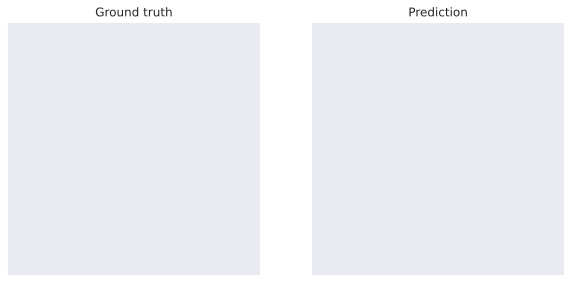

In [ ]:
#writer = animation.PillowWriter(fps=30) 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_info = []
for ax_i, (label, rollout_field) in enumerate(
    [("Ground truth", "ground_truth_rollout"),
      ("Prediction", "predicted_rollout")]):
  # Append the initial positions to get the full trajectory.
  trajectory = np.concatenate([
      rollout_data["initial_positions"],
      rollout_data[rollout_field]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = rollout_data["metadata"]["bounds"]
  ax.set_xlim(bounds[0][0]-0.2, bounds[0][1]+0.2)
  ax.set_ylim(bounds[1][0]-0.2, bounds[1][1]+0.2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  plot_info.append((ax, trajectory, points))
num_steps = trajectory.shape[0]



In [ ]:
trajectory.shape

(1000, 482, 2)

In [ ]:
def update(step_i):
  outputs = []
  for _, trajectory, points in plot_info:
    for particle_type, line in points.items():
      mask = rollout_data["particle_types"] == particle_type
      line.set_data(trajectory[step_i, mask, 0],
                    trajectory[step_i, mask, 1])
      outputs.append(line)
  return outputs


In [ ]:
result = update(0)

In [ ]:
frames=np.arange(0, num_steps, step_stride)

In [ ]:
animation_case = animation.FuncAnimation(fig,update,frames=frames, interval=5)

In [ ]:
from IPython.display import HTML
HTML(animation_case.to_html5_video())